In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

In [2]:
# making the cramer rao lower bound plots
# essentially, how well you can constrain the position of something is given by how much its gradient changes
# first, we need to generate airy disc and toliman psfs. 

# but before that, get our imports done
import dLux as dl
import dLuxToliman as dlT
# gonna use normal numpy. jax numpy is weird.
import numpy as np
from matplotlib import pyplot as plt
import dLux.utils as dlu
import jax
import jax.random as jr

# let's create the toliman pupil and obstructions, call it tolOptics

# might as well use 1024 pixels wavefront. nice and large number
wf_npixels = 128

# same for psf
psf_npixels = 16

# no need for oversampling
oversample = 1 # don't change

# toliman pixel scale
psf_pixel_scale = 0.375

tolOptics = dlT.TolimanOpticalSystem(wf_npixels, psf_npixels, oversample, psf_pixel_scale)

# now let's extract the pupil
tolPupil = tolOptics.pupil.opd

# make it a nice phase difference instead of OPD
tolPupilPhase = dlu.opd2phase(tolPupil, 585e-9) # it is pi phase difference for 585e-9 wavelength

# layer
tolPupilLayer = dl.layers.AberratedLayer(phase=tolPupilPhase)

# (normal toliman diameter)
diameter = 0.125

# initialsing coords for circular aperture
coords = dlu.pixel_coords(wf_npixels,diameter)

# x = np.arange(wf_npixels)
# y = np.arange(wf_npixels)
# X, Y = np.meshgrid(x,y, indexing = 'ij') # I believe the indexing part is neccessary? Anyway doesn't break anything

# creating the aperture (circular)
airyAperture = dlu.circle(coords,0.5 * diameter)

# making it a layer
airyApertureLayer = dl.layers.TransmissiveLayer(transmission=airyAperture, normalise=True)

# making the optical systems
tolPupilLayers = [
    (
        'aperture',
        airyApertureLayer
    ),
    (
        'pupil',
        tolPupilLayer
    )
]

airyApertureLayers = [
    (
        'aperture',
        airyApertureLayer
    )
]

tolPupilSystem = dl.AngularOpticalSystem(wf_npixels, diameter, tolPupilLayers, psf_npixels, psf_pixel_scale, oversample)

airyApertureSystem = dl.AngularOpticalSystem(wf_npixels, diameter, airyApertureLayers, psf_npixels, psf_pixel_scale, oversample)

In [3]:
# main stuff
# now... generate a lot of them for many photon counts and get some numbers
fluxes = np.logspace(3,6,4)

# just monochromatic
wavelengths = np.linspace(585e-9,585e-9,1)
# monochromatic
weights = np.linspace(1,1,1)

# at 0,0
position = dlu.arcsec2rad(np.array([0,0]))

airyCramer = np.zeros_like(fluxes)
tolCramer = np.zeros_like(fluxes)

# for photon noise
total_samples = 20

# setting up noise psfs
airyPsfNoise = np.zeros((fluxes.shape[0], total_samples, psf_npixels, psf_npixels))
tolPsfNoise = np.zeros((fluxes.shape[0], total_samples, psf_npixels, psf_npixels))

# many photons
for i, flux in enumerate(fluxes):
    # source
    source = dl.PointSource(wavelengths, position, flux, weights)

    airyPsf = airyApertureSystem.model(source)

    tolPsf = tolPupilSystem.model(source)

    # need to now make functions calculating the gradient
    # do we need pixel scale?

    # initialising derivative array
    airyPsfDx = np.zeros_like(airyPsf)

    # first column (forward difference)
    airyPsfDx[:, 0] = airyPsf[:, 1] - airyPsf[:, 0]

    # middle columns (middle difference)
    airyPsfDx[:, 1:-1] = (airyPsf[:, 2:] - airyPsf[:, :-2])/2

    # final column (backwards difference)
    airyPsfDx[:, -1] = airyPsf[:, -1] - airyPsf[:, -2]

    # now for toliman
    # initialising derivative array
    tolPsfDx = np.zeros_like(tolPsf)

    # first column (forward difference)
    tolPsfDx[:, 0] = tolPsf[:, 1] - tolPsf[:, 0]

    # middle columns (middle difference)
    tolPsfDx[:, 1:-1] = (tolPsf[:, 2:] - tolPsf[:, :-2])/2

    # final column (backwards difference)
    tolPsfDx[:, -1] = tolPsf[:, -1] - tolPsf[:, -2]

    airyInverseDiffSquare = np.sum(airyPsfDx**2/airyPsf)
    tolInverseDiffSquare = np.sum(tolPsfDx**2/tolPsf)

    airyCramer[i] = psf_pixel_scale*1/np.sqrt(airyInverseDiffSquare)
    tolCramer[i] = psf_pixel_scale*1/np.sqrt(tolInverseDiffSquare)

    # now let's do it for some random samples from poisson distribution
    
    samples = np.arange(0,total_samples,1)

    for sample in samples:

        airyPsfNoise[i, sample] = jr.poisson(jr.PRNGKey(sample),airyPsf) 
        tolPsfNoise[i, sample] = jr.poisson(jr.PRNGKey(sample),tolPsf) 

In [4]:
# now we want to infer the x-position (just 1 parameter), setting y-position to 0.
# first multithreaded stuff

import numpyro as npy
import numpyro.distributions as dist
import jax.numpy as jnp

parameters = ['position']

def psf_model(data, model):
    """
    Define the numpyro model
    """

    values = [
        jnp.array([dlu.arcsec2rad(npy.sample("x_pos", dist.Uniform(-0.1,0.1))),0]),
      ]  
    
    with npy.plate("data", len(data.flatten())):
        poisson_model = dist.Poisson(
            model.set(parameters, values).model().flatten())
        return npy.sample("psf", poisson_model, obs=data.flatten())




In [8]:
# cycling through all fluxes, and calculating mean x poses, standard deviations
x_positionsAiry = np.zeros((fluxes.shape[0],total_samples))

In [12]:
index = 3
#defining the source
wavelengths = np.linspace(585e-9,585e-9,1)
    
weights = np.linspace(1,1,1)

position = dlu.arcsec2rad(np.array([0,0]))

source = dl.PointSource(wavelengths, position, fluxes[index], weights)

# defining telescope
airyTelescope = dl.Telescope(airyApertureSystem, ('source', source))

for sample in samples:
    data = airyPsfNoise[index, sample]
    telescope = airyTelescope

    sampler = npy.infer.MCMC(
        npy.infer.NUTS(psf_model),    
        num_warmup=2000,
        num_samples=2000,
        num_chains=4,
        progress_bar=False,
    )

    %time sampler.run(jr.PRNGKey(0), data, telescope)
    x_positionsAiry[index, sample] = np.mean(sampler.get_samples()["x_pos"])
    print(sample)
    print(x_positionsAiry[index,sample])
    
    

CPU times: user 1.9 s, sys: 60.1 ms, total: 1.96 s
Wall time: 1.07 s
0
-0.0003512940020300448
CPU times: user 1.85 s, sys: 62.1 ms, total: 1.91 s
Wall time: 996 ms
1
-0.00032783206552267075
CPU times: user 1.74 s, sys: 53.2 ms, total: 1.79 s
Wall time: 871 ms
2
-0.0001437015744158998
CPU times: user 1.86 s, sys: 54.8 ms, total: 1.92 s
Wall time: 991 ms
3
0.0003800584527198225
CPU times: user 1.86 s, sys: 61.8 ms, total: 1.92 s
Wall time: 997 ms
4
-0.004315505735576153
CPU times: user 1.75 s, sys: 48.8 ms, total: 1.8 s
Wall time: 876 ms
5
-5.794734533992596e-06
CPU times: user 1.77 s, sys: 50 ms, total: 1.82 s
Wall time: 890 ms
6
0.00012161697668489069
CPU times: user 1.88 s, sys: 58.9 ms, total: 1.94 s
Wall time: 997 ms
7
-0.00024356506764888763
CPU times: user 1.88 s, sys: 58.8 ms, total: 1.94 s
Wall time: 1.01 s
8
-0.00017264856433030218
CPU times: user 1.88 s, sys: 60.2 ms, total: 1.94 s
Wall time: 996 ms
9
-0.0005940313567407429
CPU times: user 1.88 s, sys: 60.2 ms, total: 1.94 s
W

In [17]:
# mean error:
print(np.mean(np.abs(x_positionsAiry[2])))

0.0007592611793370452


In [18]:
# cycling through all fluxes, and calculating mean x poses, standard deviations
x_positionsTol = np.zeros((fluxes.shape[0],total_samples))

In [22]:
index = 3
#defining the source
wavelengths = np.linspace(585e-9,585e-9,1)
    
weights = np.linspace(1,1,1)

position = dlu.arcsec2rad(np.array([0,0]))

source = dl.PointSource(wavelengths, position, fluxes[index], weights)

# defining telescope
tolTelescope = dl.Telescope(tolPupilSystem, ('source', source))

for sample in samples:
    data = airyPsfNoise[index, sample]
    telescope = tolTelescope

    sampler = npy.infer.MCMC(
        npy.infer.NUTS(psf_model),    
        num_warmup=2000,
        num_samples=2000,
        num_chains=4,
        progress_bar=False,
    )

    %time sampler.run(jr.PRNGKey(0), data, telescope)
    x_positionsTol[index, sample] = np.mean(sampler.get_samples()["x_pos"])
    print(sample)
    print(x_positionsTol[index,sample])

CPU times: user 1.86 s, sys: 67.1 ms, total: 1.93 s
Wall time: 1.03 s
0
0.0260618906468153
CPU times: user 1.86 s, sys: 60.7 ms, total: 1.92 s
Wall time: 1 s
1
0.026508118957281113
CPU times: user 1.87 s, sys: 63.7 ms, total: 1.93 s
Wall time: 1.01 s
2
0.02362634800374508
CPU times: user 1.86 s, sys: 57.5 ms, total: 1.92 s
Wall time: 999 ms
3
0.023085568100214005
CPU times: user 1.87 s, sys: 62.8 ms, total: 1.93 s
Wall time: 1 s
4
0.020982854068279266
CPU times: user 1.86 s, sys: 59.7 ms, total: 1.92 s
Wall time: 1e+03 ms
5
0.020320383831858635
CPU times: user 1.87 s, sys: 60.6 ms, total: 1.93 s
Wall time: 999 ms
6
0.021664392203092575
CPU times: user 1.88 s, sys: 63.7 ms, total: 1.94 s
Wall time: 997 ms
7
0.026193836703896523
CPU times: user 1.87 s, sys: 63.2 ms, total: 1.93 s
Wall time: 1.01 s
8
0.023286115378141403
CPU times: user 1.87 s, sys: 66.8 ms, total: 1.93 s
Wall time: 1.01 s
9
0.02472544275224209
CPU times: user 1.89 s, sys: 74.2 ms, total: 1.96 s
Wall time: 1.02 s
10
-0.00

In [ ]:
print(fluxes)
print(airyCramer[0])
print(np.mean(np.abs(x_positionsAiry)))

In [28]:
tolXMeans = np.zeros_like(fluxes)
airyXMeans = np.zeros_like(fluxes)
tolXSDs = np.zeros_like(fluxes)
airyXSDs = np.zeros_like(fluxes)
for i, flux in enumerate(fluxes):
    airyXMeans[i] = np.mean(np.abs(x_positionsAiry[i]))
    airyXSDs[i] = np.std(np.abs(x_positionsAiry[i]))
    tolXMeans[i] = np.mean(np.abs(x_positionsTol[i]))
    tolXSDs[i] = np.std(np.abs(x_positionsTol[i]))

In [40]:
print(airyXSDs)
print(airyXMeans)

[0.00530477 0.00178352 0.00049901 0.00146688]
[0.00765407 0.00254236 0.00075926 0.00085549]


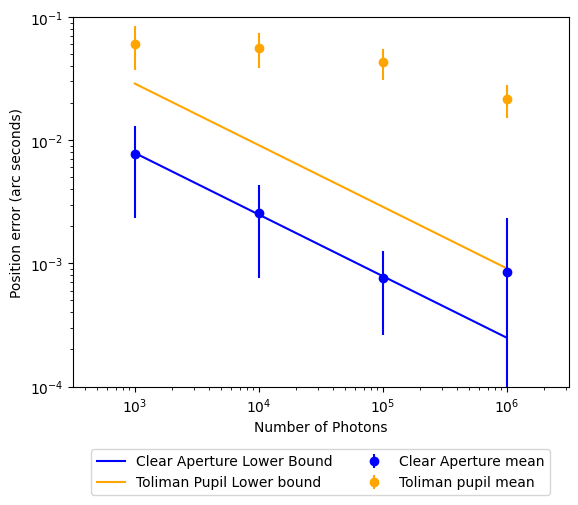

In [45]:
plt.loglog(fluxes,airyCramer,label='Clear Aperture Lower Bound', color='blue')
plt.loglog(fluxes,tolCramer,label='Toliman Pupil Lower bound', color='orange')

# Plot means as dots with error bars
plt.errorbar(fluxes, airyXMeans, yerr=airyXSDs, fmt='o', label='Clear Aperture mean', color='blue')
plt.errorbar(fluxes, tolXMeans, yerr=tolXSDs, fmt='o', label='Toliman pupil mean', color='orange')

plt.xlim(1*10**(2.5),1*10**(6.5))
plt.ylim(10**(-4),10**(-1))
plt.xlabel('Number of Photons')
plt.ylabel('Position error (arc seconds)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()